# Stock Prediction

Inspiration from https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

In [163]:
# Imports

# Math imports
import math

# Data imports
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import datetime

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('figure', figsize=(8, 7))

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing

In [119]:
# Getting Neflix data

start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2019, 9, 1)

nflx = web.DataReader("NFLX", 'yahoo', start, end)

In [120]:
nflx.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,10.388572,10.018572,10.040000,10.320000,29213800.0,10.320000
2012-01-04,11.567142,10.258572,10.335714,11.492857,100489900.0,11.492857
2012-01-05,11.694285,11.040000,11.345715,11.328571,86552900.0,11.328571
2012-01-06,12.471429,11.242857,11.302857,12.327143,125610800.0,12.327143
2012-01-09,14.235714,12.448571,12.801429,14.025714,214073300.0,14.025714


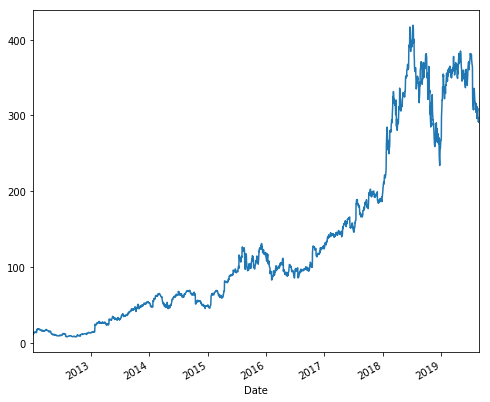

In [121]:
# Plotting the closed prices

nflx['Adj Close'].plot()

## Quick Dirty Predictions

With no feature engineering

What we will be predicting is the Adjusted Closing Price (instead of Closing Price: https://www.investopedia.com/terms/a/adjusted_closing_price.asp).

In [122]:
# Checking to see if there are any missing values

[sum(nflx[col].isnull()) for col in nflx.columns]

[0, 0, 0, 0, 0, 0]

In [138]:
# Creating a column for forecasting values

nflx['Forecast'] = np.nan

In [139]:
# Separating the data into features (X) and target (y)

X = nflx.loc[:,['High','Low','Open','Volume']]
y = nflx.loc[:,['Adj Close']]

In [142]:
# Getting the amount of data to forecast

forecast_data = int(math.ceil(0.1 * len(X)))

In [143]:
# Splitting data into train, and test sets

X_train = X[:-forecast_data]
y_train = y[:-forecast_data]

X_test = X[-forecast_data:]
y_test = y[-forecast_data:]

In [145]:
# Checking to see the size of each set

print(X_train.shape)
print(X_test.shape)
print(X.shape)

(1735, 4)
(193, 4)
(1928, 4)


In [146]:
# Function for a dirty algorithm

def linear_alg_score(alg):
    alg.fit(X_train, y_train)
    return [alg, alg.score(X_test, y_test), alg.coef_, alg.intercept_]

In [153]:
# Function to plot predictions with actual values

def comparison(alg):
    temp = pd.DataFrame({'actual':y_test.values.reshape(-1,1).flatten(), 'predictions':alg.predict(X_test).flatten()})
    plt.plot(temp['actual'], color='red')
    plt.plot(temp['predictions'], color='blue', alpha=0.3)
    plt.legend()
    plt.show()

The three regression models we will be using is ridge, lasso, and elastic net

In [148]:
# Running a Ridge Regression

dirty_ridge = linear_model.Ridge(alpha=0.5)
dirty_ridge_results = linear_alg_score(dirty_ridge)

In [149]:
# Ridge Regression - Viewing the results

dirty_ridge_results

[Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 0.9932262313236064,
 array([[ 8.61825449e-01,  7.99079861e-01, -6.60650986e-01,
          7.44073608e-10]]),
 array([-0.04375551])]

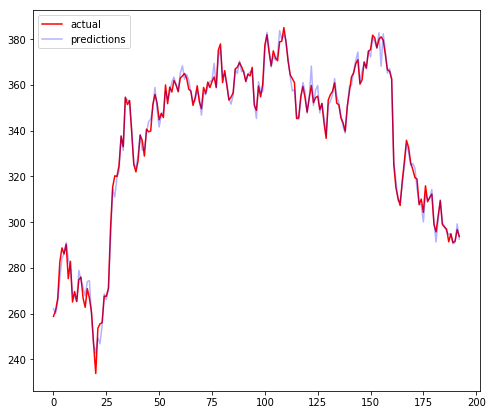

In [154]:
# Ridge Regression - Plotting the results

comparison(dirty_ridge_results[0])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


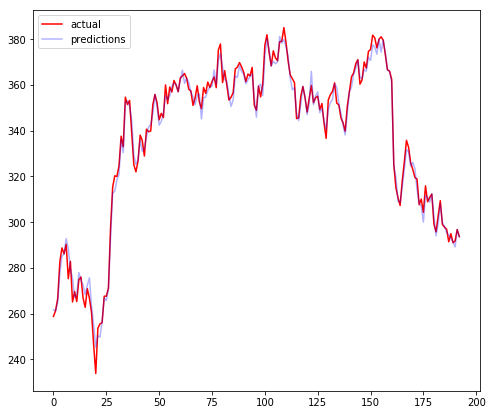

In [155]:
# Running a Lasso Regression

dirty_lasso = linear_model.Lasso(alpha=0.5)
dirty_lasso_results = linear_alg_score(dirty_lasso)
comparison(dirty_lasso_results[0])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


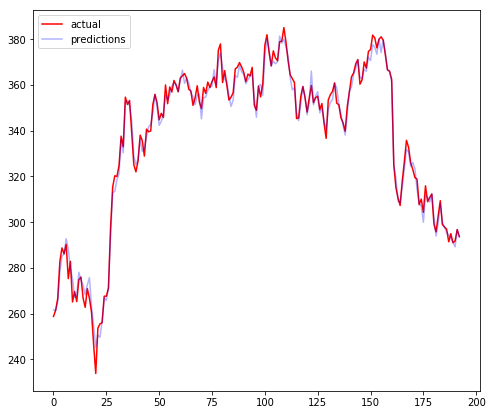

In [156]:
# Elastic Net Regression

dirty_enet = linear_model.ElasticNet(alpha=0.5, l1_ratio=0.7)
dirty_enet_results = linear_alg_score(dirty_enet)
comparison(dirty_enet_results[0])

# Towards Data Science Approach

In [160]:
# Feature engineering the data

tds = nflx.loc[:,['Adj Close','Volume']]
tds['HL_PCT'] = (nflx['High'] - nflx['Low']) / nflx['Close'] * 100.0
tds['PCT_change'] = (nflx['Close'] - nflx['Open']) / nflx['Open'] * 100.0

In [164]:
# Filling in missing values with 
tds.fillna(value=-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(tds)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
tds['label'] = tds[forecast_col].shift(-forecast_out)
X = np.array(tds.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(tds['label'])
y = y[:-forecast_out]

In [165]:
# Training and test set

num = int(math.ceil(0.2 * len(tds)))

X_train = X[:num]
X_test = X[num:]
y_train = y[:num]
y_test = y[num:]

In [166]:
tds_ridge = linear_model.Ridge(alpha=0.5)
tds_ridge_results = linear_alg_score(tds_ridge)

In [167]:
tds_ridge_results[1:]

[0.8716327600528389,
 array([ 9.46316789e+01, -3.23960087e-01,  2.28427077e-01,  7.12104227e-02]),
 112.61901521616592]

In [168]:
forecast_set = tds_ridge_results[0].predict(X_lately)
tds['Forecast'] = np.nan

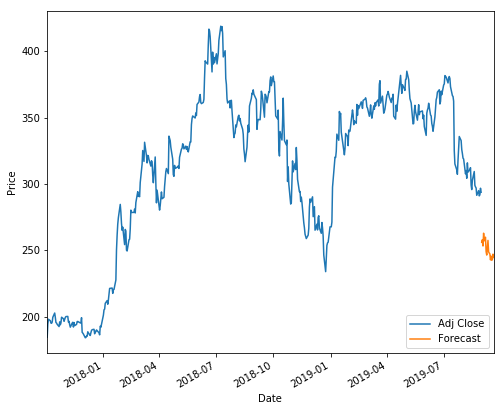

In [169]:
last_date = tds.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    tds.loc[next_date] = [np.nan for _ in range(len(tds.columns)-1)]+[i]
tds['Adj Close'].tail(500).plot()
tds['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()